In [154]:
import copy
import itertools
import os
import operator
import pandas as pd
import pickle
import random
import sklearn
import powerlaw
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from gensim.models import Word2Vec, KeyedVectors
from scipy.io import loadmat, savemat
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.spatial import distance
from sklearn.preprocessing import normalize
from sklearn.neighbors import BallTree

sns.set()

# Load Graph and Embeddings

In [2]:
blog = loadmat('/home/hcchen/fast-random-projection/example_graphs/blogcatalog.mat')
A = blog['network']
A

<10312x10312 sparse matrix of type '<class 'numpy.float64'>'
	with 667966 stored elements in Compressed Sparse Column format>

In [284]:
d = np.squeeze(np.asarray(A.sum(axis=1)))

In [4]:
d_log = map(math.log, d)

Load embeddings:

In [5]:
rp_emb = loadmat('/home/hcchen/fast-random-projection/result/blog-randne-emb.mat')['emb']

In [6]:
dw_model = KeyedVectors.load_word2vec_format('/home/hcchen/fast-random-projection/result/blogcatalog-dw.emb')
N = len(dw_model.vocab)
dw_emb = np.asarray([dw_model[str(node)] for node in range(N)])

# Distance Between Nodes of Different Degree Tiers

Array of degree tiers:

In [302]:
eps = 1e-6
tier_base = 2

In [303]:
np.log(8) / np.log(2)

3.0

In [304]:
d_tier = list(map(lambda x: int( np.log(x) / np.log(tier_base) + eps), d))
d_tier[:20]

[6, 3, 6, 2, 6, 8, 7, 1, 5, 8, 7, 1, 7, 6, 7, 6, 7, 2, 4, 4]

In [305]:
from collections import Counter
sorted(Counter(d_tier).items())

[(0, 270),
 (1, 725),
 (2, 1380),
 (3, 1975),
 (4, 1929),
 (5, 1736),
 (6, 1187),
 (7, 630),
 (8, 306),
 (9, 113),
 (10, 40),
 (11, 21)]

In [306]:
T = max(d_tier) + 1
T

12

Distance between embeddings of nodes of different tiers:

In [13]:
%%time
emb_dist_mat = [[[] for i in range(T)] for j in range(T)]
for i in range(N):
    if i % 100 == 0:
        print (i)
    for j in range(i + 1, N):
        t1, t2 = d_tier[i], d_tier[j]
        cur_dist = distance.euclidean(dw_emb[i], dw_emb[j])
        emb_dist_mat[t1][t2].append(cur_dist)
        emb_dist_mat[t2][t1].append(cur_dist)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300


In [18]:
emb_dist_avg = [ [np.mean(emb_dist_mat[i][j]) for i in range(T)] for j in range(T)]

In [22]:
pd.DataFrame(emb_dist_avg)

,0,1,2,3,4,5,6,7,8,9,10
0,4.016834,3.852030,3.718139,3.593149,3.470130,3.374352,3.296530,3.239761,3.202446,3.123710,4.035625
1,3.852030,3.665345,3.518936,3.386848,3.256973,3.157335,3.076944,3.021134,2.985695,2.900887,3.881498
2,3.718139,3.518936,3.359849,3.217558,3.079264,2.974132,2.890728,2.834602,2.801236,2.712799,3.752934
3,3.593149,3.386848,3.217558,3.064878,2.916418,2.802916,2.713112,2.654098,2.622358,2.532092,3.628705
4,3.470130,3.256973,3.079264,2.916418,2.756851,2.632725,2.534028,2.469696,2.438096,2.345481,3.504825
5,3.374352,3.157335,2.974132,2.802916,2.632725,2.497361,2.388762,2.317921,2.285579,2.191171,3.407532
6,3.296530,3.076944,2.890728,2.713112,2.534028,2.388762,2.269119,2.188845,2.153816,2.059307,3.325953
7,3.239761,3.021134,2.834602,2.654098,2.469696,2.317921,2.188845,2.100044,2.058155,1.960430,3.264767
8,3.202446,2.985695,2.801236,2.622358,2.438096,2.285579,2.153816,2.058155,2.003527,1.893989,3.221495
9,3.123710,2.900887,2.712799,2.532092,2.345481,2.191171,2.059307,1.960430,1.893989,1.755431,3.139095


Text(0.5, 1.0, 'Average Distance between Nodes of Different Tiers')

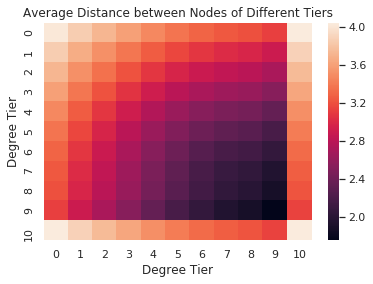

In [25]:
sns.heatmap(emb_dist_avg)
plt.xlabel('Degree Tier')
plt.ylabel('Degree Tier')
plt.title('Average Distance between Nodes of Different Tiers')

# Ratio of Edges Between Different Tiers

In [36]:
cx = A.tocoo()

In [39]:
edge_count = [[0 for i in range(T)] for j in range(T)]

In [40]:
for i, j, _ in zip(cx.row, cx.col, cx.data):
    t1, t2 = d_tier[i], d_tier[j]
    edge_count[t1][t2] += 1
    edge_count[t2][t1] += 1

In [48]:
edge_count_normed = normalize(np.asarray(edge_count), axis=0, norm='l1')

In [49]:
edge_count_normed

array([[0.00110988, 0.00134102, 0.00104965, 0.0009671 , 0.00104617,
        0.00161925, 0.00155345, 0.00232382, 0.0047291 , 0.00417486,
        0.00790847],
       [0.00554939, 0.00563229, 0.00520263, 0.00451311, 0.00474605,
        0.00569562, 0.00677053, 0.00901072, 0.01646238, 0.01901114,
        0.03629647],
       [0.0127636 , 0.01528765, 0.01542534, 0.01646365, 0.01661117,
        0.01784   , 0.02130831, 0.02755383, 0.04566776, 0.05860332,
        0.09463264],
       [0.02330744, 0.02628403, 0.03263052, 0.03504571, 0.03564639,
        0.04018   , 0.04889328, 0.06189889, 0.08967395, 0.11299727,
        0.14983053],
       [0.04550499, 0.04988601, 0.0594195 , 0.06433489, 0.07195621,
        0.08407863, 0.09828941, 0.1229631 , 0.1574151 , 0.19143981,
        0.21406668],
       [0.0954495 , 0.08113182, 0.08648229, 0.09827535, 0.11394343,
        0.1301237 , 0.14992143, 0.17992033, 0.20361968, 0.22668461,
        0.21148432],
       [0.09600444, 0.10111305, 0.10829682, 0.12537705, 0.

Text(0.5, 1.0, 'Ratio of Edges between Nodes of Different Tiers')

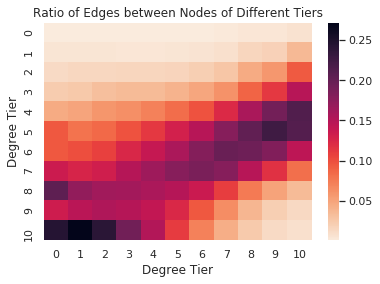

In [51]:
sns.heatmap(edge_count_normed, cmap=sns.cm.rocket_r)
plt.xlabel('Degree Tier')
plt.ylabel('Degree Tier')
plt.title('Ratio of Edges between Nodes of Different Tiers')

# Erdos-Renyi Model

Randomly connect to existing nodes:

In [76]:
tuple(random.sample(range(4), 2))

(1, 0)

In [307]:
M = int(A.sum() / 2 + 1e-8)
M

333983

In [91]:
cur_sampled_edges = set()
for i in range(M):
    while True:
        edge = tuple(random.sample(range(N), 2) )
        if edge not in cur_sampled_edges:
            cur_sampled_edges.add(edge)
            break

In [93]:
er_edge_count = [[0 for i in range(T)] for j in range(T)]

In [308]:
d = [0 for _ in range(N)]
for u, v in cur_sampled_edges:
    d[u] += 1
    d[v] += 1
d_tier = list(map(lambda x: int( np.log(x) / np.log(tier_base) + eps) - 1, d))
d_tier[:20]

[5, 5, 5, 5, 4, 4, 4, 5, 5, 5, 4, 4, 5, 5, 5, 4, 5, 4, 5, 4]

Number of nodes by degree tier:

In [309]:
sorted(Counter(d_tier).items())

[(4, 4614), (5, 5698)]

In [134]:
for u, v in cur_sampled_edges:
    t1, t2 = d_tier[u], d_tier[v]
    er_edge_count[t1][t2] += 1
    er_edge_count[t2][t1] += 1

In [135]:
er_edge_count_normed = normalize(np.asarray(er_edge_count), axis=0, norm='l1')

Text(0.5, 1.0, 'Ratio of Edges between Nodes of Different Tiers')

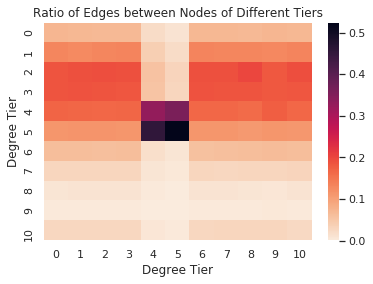

In [136]:
sns.heatmap(er_edge_count_normed, cmap=sns.cm.rocket_r)
plt.xlabel('Degree Tier')
plt.ylabel('Degree Tier')
plt.title('Ratio of Edges between Nodes of Different Tiers')

# BA Model

In [240]:
M / N

32.38780062063615

In [271]:
G_ba = nx.barabasi_albert_graph(N, int(M / N) )

In [272]:
G_ba.number_of_edges()

328960

In [310]:
d = [d for n, d in G_ba.degree()]
d_tier = list(map(lambda x: int( np.log(x) / np.log(tier_base) + eps) - 1, d))
d_tier[1000:1020]

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5]

Number of nodes by degree tier:

In [311]:
sorted(Counter(d_tier).items())

[(4, 7682), (5, 1939), (6, 492), (7, 153), (8, 46)]

In [245]:
ba_edge_count = [[0 for i in range(T)] for j in range(T)]

In [246]:
for u, v in G.edges():
    t1, t2 = d_tier[u], d_tier[v]
    ba_edge_count[t1][t2] += 1
    ba_edge_count[t2][t1] += 1

In [247]:
ba_edge_count_normed = normalize(np.asarray(ba_edge_count), axis=0, norm='l1')

Text(0.5, 1.0, 'Ratio of Edges between Nodes of Different Tiers')

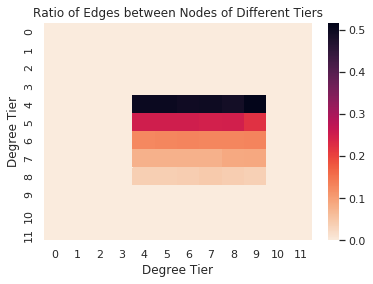

In [248]:
sns.heatmap(ba_edge_count_normed, cmap=sns.cm.rocket_r)
plt.xlabel('Degree Tier')
plt.ylabel('Degree Tier')
plt.title('Ratio of Edges between Nodes of Different Tiers')

In [249]:
G_ba_edge_set = G_to_edge_set(G_ba)

In [250]:
G_real = nx.from_scipy_sparse_matrix(A)

In [251]:
G_real.number_of_edges()

333983

In [252]:
G_real_edge_set = G_to_edge_set(G_real)

In [254]:
len(G_ba_edge_set.intersection(G_real_edge_set)) / G_real.number_of_edges()

0.0071740178392313385

# Nearest Neighbor Model

Connect each node to its nearest neighbor according to DeepWalk embeddings.

First we build a ball tree:

In [155]:
%time tree = BallTree(dw_emb)

CPU times: user 70.3 ms, sys: 4.02 ms, total: 74.3 ms
Wall time: 72.7 ms


Connect edges based on L2 distance:

In [186]:
%%time
nn_edges = set()
for u in range(N):
    k = A[u].count_nonzero()
    if u % 1000 == 0:
        print (u)
    dist, ind = tree.query(dw_emb[u: u + 1], k=k+1)
    neighbors = ind[0][1:]
    for neighbor in neighbors:
        cur_edge = (neighbor, u) if neighbor < u else (u, neighbor)
        if cur_edge not in nn_edges:
            nn_edges.add(cur_edge)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
CPU times: user 37 s, sys: 99.2 ms, total: 37.1 s
Wall time: 37.1 s


In [189]:
G_nn = nx.Graph()

In [190]:
G_nn.add_edges_from(nn_edges)

In [312]:
G_nn.number_of_edges()

524878

This is going to add more edges than the original graph...

In [187]:
len(nn_edges)

524878

In [315]:
d = [d for n, d in G_nn.degree()]
d_tier = list(map(lambda x: int( np.log(x) / np.log(tier_base) + eps), d))
d_tier[1000:1020]

[5, 7, 7, 6, 10, 2, 9, 6, 8, 5, 9, 9, 8, 7, 7, 6, 2, 6, 7, 8]

Number of nodes by degree tier:

In [316]:
sorted(Counter(d_tier).items())

[(0, 183),
 (1, 651),
 (2, 1289),
 (3, 1860),
 (4, 1851),
 (5, 1484),
 (6, 1192),
 (7, 789),
 (8, 566),
 (9, 299),
 (10, 116),
 (11, 30),
 (12, 2)]

## Average Distance

Distance between embeddings of nodes of different tiers:

In [330]:
%%time
emb_dist_mat_nn = [[[] for i in range(T)] for j in range(T)]
for u, v in G_nn.edges():
    t1, t2 = d_tier[u], d_tier[v]
    cur_dist = distance.euclidean(dw_emb[u], dw_emb[v])
    emb_dist_mat_nn[t1][t2].append(cur_dist)
    emb_dist_mat_nn[t2][t1].append(cur_dist)

CPU times: user 6.87 s, sys: 16 ms, total: 6.88 s
Wall time: 6.88 s


In [332]:
emb_dist_avg_nn = [ [np.mean(emb_dist_mat_nn[i][j]) for i in range(T)] for j in range(T)]

In [333]:
pd.DataFrame(emb_dist_avg_nn)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2.232456,2.215067,2.151824,2.141390,2.118565,2.088588,2.066011,2.068897,2.050791,2.045828,2.061875,2.064185,NaN
1,2.215067,2.193531,2.144129,2.123987,2.105733,2.085833,2.078458,2.093253,2.078301,2.079701,2.074969,2.073725,2.122821
2,2.151824,2.144129,2.091596,2.075836,2.058127,2.026551,2.017245,2.025797,2.016017,2.016786,2.031244,2.015656,2.000313
3,2.141390,2.123987,2.075836,2.063983,2.050949,2.019509,2.010883,2.018677,2.011899,2.007888,2.017625,1.996804,2.009284
4,2.118565,2.105733,2.058127,2.050949,2.045237,2.013378,2.004027,2.009990,2.005910,1.998075,2.010409,1.997775,2.006550
5,2.088588,2.085833,2.026551,2.019509,2.013378,1.981645,1.969255,1.975600,1.965826,1.953323,1.976204,1.948291,1.982398
6,2.066011,2.078458,2.017245,2.010883,2.004027,1.969255,1.952065,1.961650,1.948728,1.939150,1.952108,1.926595,2.057792
7,2.068897,2.093253,2.025797,2.018677,2.009990,1.975600,1.961650,1.968796,1.960819,1.943287,1.968710,1.936945,2.079154
8,2.050791,2.078301,2.016017,2.011899,2.005910,1.965826,1.948728,1.960819,1.948760,1.935894,1.953127,1.915744,1.931758
9,2.045828,2.079701,2.016786,2.007888,1.998075,1.953323,1.939150,1.943287,1.935894,1.917297,1.953113,1.888856,1.955400


Text(0.5, 1.0, 'Average Distance between Nodes of Different Tiers')

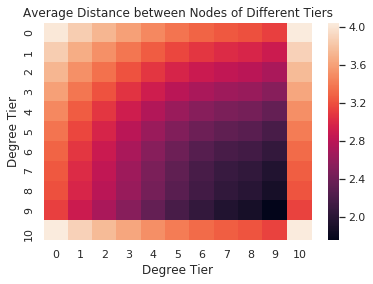

In [336]:
sns.heatmap(emb_dist_avg)
plt.xlabel('Degree Tier')
plt.ylabel('Degree Tier')
plt.title('Average Distance between Nodes of Different Tiers')

Text(0.5, 1.0, 'Average Distance between Nodes of Different Tiers')

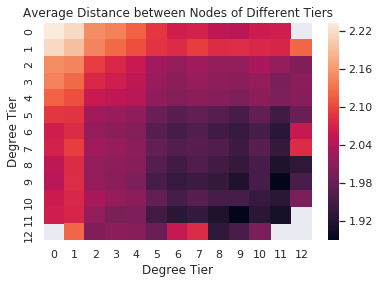

In [335]:
sns.heatmap(emb_dist_avg_nn)
plt.xlabel('Degree Tier')
plt.ylabel('Degree Tier')
plt.title('Average Distance between Nodes of Different Tiers')

## Number of Node Pairs between Different Degree Tiers

In [317]:
T = 13

In [318]:
nn_edge_count = [[0 for i in range(T)] for j in range(T)]

In [319]:
for u, v in G_nn.edges():
    t1, t2 = d_tier[u], d_tier[v]
    nn_edge_count[t1][t2] += 1
    nn_edge_count[t2][t1] += 1

In [320]:
nn_edge_count_normed = normalize(np.asarray(nn_edge_count), axis=0, norm='l1')

Text(0.5, 1.0, 'Ratio of Edges between Nodes of Different Tiers')

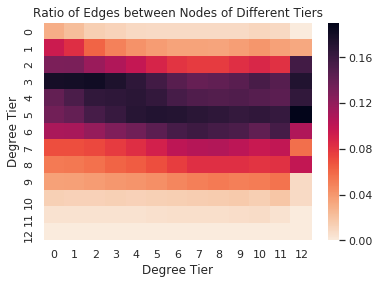

In [321]:
sns.heatmap(nn_edge_count_normed, cmap=sns.cm.rocket_r)
plt.xlabel('Degree Tier')
plt.ylabel('Degree Tier')
plt.title('Ratio of Edges between Nodes of Different Tiers')

In [233]:
def G_to_edge_set(G):
    edge_set = set()
    for (u, v) in G.edges():
        if u < v:
            edge_set.add((u, v))
        else:
            edge_set.add((v, u))
    return edge_set

In [234]:
G_nn_edge_set = G_to_edge_set(G_nn)

In [230]:
G_real = nx.from_scipy_sparse_matrix(A)

In [231]:
G_real.number_of_edges()

333983

In [235]:
G_real_edge_set = G_to_edge_set(G_real)

In [238]:
len(G_nn_edge_set.intersection(G_real_edge_set)) / G_real.number_of_edges()

0.6780644523823068

Reconstruction accuracy by node tier:

In [266]:
edges_by_tier = [[set() for i in range(T)] for j in range(T)]

for u, v in G_real.edges():
    t1, t2 = d_tier[u], d_tier[v]
    if u > v:
        u, v = v, u
    edges_by_tier[t1][t2].add((u, v))
    edges_by_tier[t2][t1].add((u, v))

In [267]:
%time acc_by_tier = [[1.0 * len(G_nn_edge_set.intersection(edges_by_tier[i][j]) ) / len(edges_by_tier[i][j]) \
                      if len(edges_by_tier[i][j]) > 0 else 0.0 \
                      for i in range(T)] for j in range(T)]

CPU times: user 462 ms, sys: 4.04 ms, total: 466 ms
Wall time: 463 ms


Text(0.5, 1.0, 'Edge Reconstruction Accuracy between Nodes of Different Tiers')

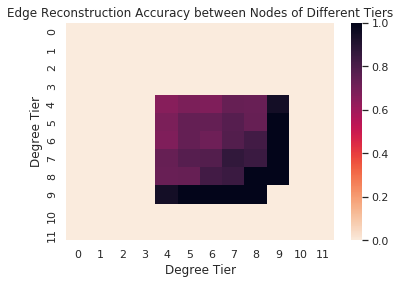

In [269]:
sns.heatmap(acc_by_tier, cmap=sns.cm.rocket_r)
plt.xlabel('Degree Tier')
plt.ylabel('Degree Tier')
plt.title('Edge Reconstruction Accuracy between Nodes of Different Tiers')

# Sergiy Model

Connect according to the BA scheme, but use embedding distance to break ties.

In [208]:
avg_d = int(M / N)
avg_d

32

In [211]:
G_s = nx.complete_graph(avg_d)

In [222]:
for u in range(avg_d, N):
    if u % 500 == 0:
        print (u)
    # ref: https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.choice.html
    p = [0.5 * d / G_s.number_of_edges() for n, d in G_s.degree]
    neighbors = np.random.choice(u, avg_d, replace=False, p=p)
    new_edges = [(u, neighbor) for neighbor in neighbors]
    G_s.add_edges_from(new_edges)

500
1000
1500


KeyboardInterrupt: 